# **Telco Customer Churn & Tenure Prediction**


## Module 1 : Imports and Setup

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for Preprocessing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error
)
from sklearn.utils import class_weight

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Set visualization style and random seed for reproducibility
sns.set_style("whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries loaded successfully.")


Libraries loaded successfully.


## Module 2 : Data Loading & EDA

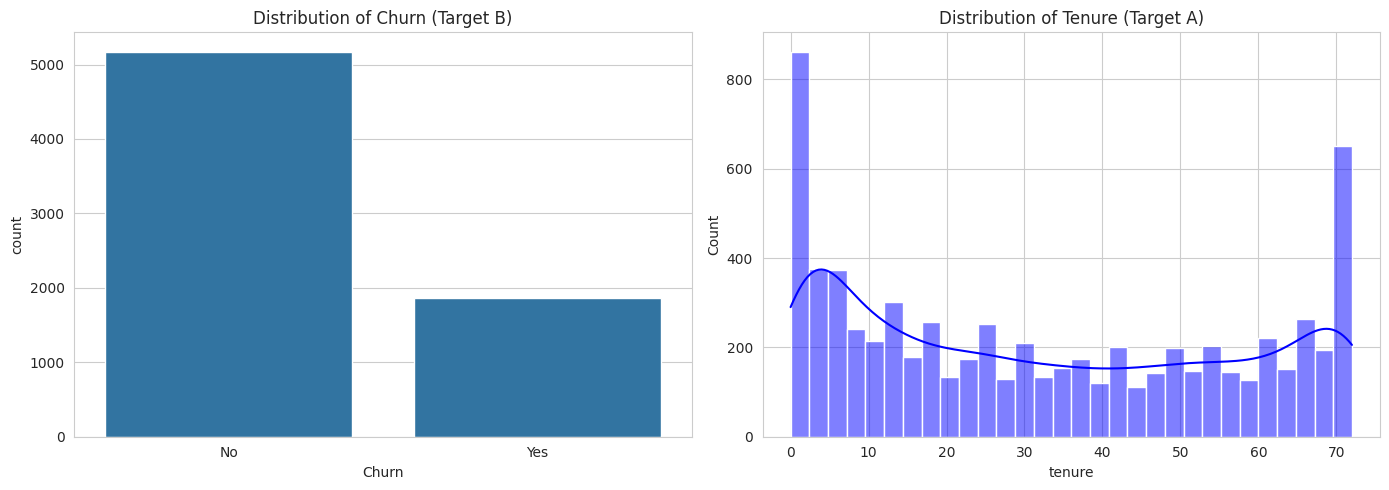

Dataset Shape: (7043, 20)
Missing Values:
0


In [13]:
# Module 2: Data Loading and Exploratory Data Analysis (EDA)

def load_and_inspect_data(filepath):
    """
    Loads dataset and performs initial cleaning of TotalCharges.
    """
    df = pd.read_csv(filepath)

    # 'TotalCharges' contains empty strings for new customers (tenure=0).
    # Coerce errors to NaN, then fill with 0.
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

    # Drop customerID as it is not a feature
    if 'customerID' in df.columns:
        df = df.drop(columns=['customerID'])

    return df

def plot_distributions(df):
    """
    Plots the distribution of Churn and Tenure.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Churn Distribution
    sns.countplot(x='Churn', data=df, ax=axes[0])
    axes[0].set_title('Distribution of Churn (Target B)')

    # Tenure Distribution
    sns.histplot(df['tenure'], bins=30, kde=True, ax=axes[1], color='blue')
    axes[1].set_title('Distribution of Tenure (Target A)')

    plt.tight_layout()
    plt.show()

# Execution
file_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = load_and_inspect_data(file_path)
plot_distributions(df)

print(f"Dataset Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum().sum()}")

## Module 3 : Preprocessing

In [14]:
# Preprocessing

def preprocess_data(df):
    """
    Encodes categorical features, splits data, and scales inputs/targets.
    """
    # 1. Encode Target (Churn)
    df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

    # 2. Define Features (X)
    # Constraint: Keep MonthlyCharges, DROP TotalCharges from inputs
    # We also exclude the targets 'tenure' and 'Churn' from X
    exclude_cols = ['tenure', 'Churn', 'TotalCharges']
    feature_cols = [c for c in df.columns if c not in exclude_cols]

    # 3. One-Hot Encoding for categorical features
    df_encoded = pd.get_dummies(df, columns=feature_cols, drop_first=True)

    # Extract X and y
    # Note: df_encoded now has the dummy variables + original numeric columns (if any)
    # We must ensure we select only input features for X
    X = df_encoded.drop(columns=['tenure', 'Churn', 'TotalCharges'], errors='ignore').values
    y_tenure = df['tenure'].values
    y_churn = df['Churn'].values

    # 4. Train/Test Split (80/20)
    X_train, X_test, y_ten_train, y_ten_test, y_churn_train, y_churn_test = train_test_split(
        X, y_tenure, y_churn, test_size=0.2, random_state=42
    )

    # 5. Scaling
    # Scale Features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    # Scale Tenure Target (Crucial for Regression convergence)
    scaler_tenure = StandardScaler()
    y_ten_train_scaled = scaler_tenure.fit_transform(y_ten_train.reshape(-1, 1))
    y_ten_test_scaled = scaler_tenure.transform(y_ten_test.reshape(-1, 1))

    return (X_train_scaled, X_test_scaled,
            y_ten_train_scaled, y_ten_test_scaled,
            y_churn_train, y_churn_test,
            scaler_tenure, y_ten_test)

# Execution
(X_train, X_test, y_ten_train_s, y_ten_test_s, y_churn_train, y_churn_test,
 scaler_tenure, y_ten_test_raw) = preprocess_data(df)

print("Preprocessing complete.")
print(f"Input Features: {X_train.shape[1]}")

Preprocessing complete.
Input Features: 1611


## Module 4: Approach A (Tenure Regression)

In [15]:
# Approach A - Predicting Tenure (Regression)

def build_tenure_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')  # Linear activation for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train
model_a = build_tenure_model(X_train.shape[1])
history_a = model_a.fit(
    X_train, y_ten_train_s,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate
pred_tenure_s = model_a.predict(X_test)
# Inverse transform to get actual months
pred_tenure_a = scaler_tenure.inverse_transform(pred_tenure_s)
mae_a = mean_absolute_error(y_ten_test_raw, pred_tenure_a)

print(f"Approach A - Tenure Mean Absolute Error: {mae_a:.4f} months")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Approach A - Tenure Mean Absolute Error: 15.4555 months


## Module 5: Approach B (Churn Classification)

In [17]:
# Module 5: Approach B - Predicting Churn (Classification)

# Function to build the model architecture
def build_churn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 1. Unbalanced Training (Capturing history now)
print("Training Unbalanced Model...")
model_b_unbal = build_churn_model(X_train.shape[1])

# CORRECTED: We assign the result of .fit() to a variable 'history_b_unbal'
history_b_unbal = model_b_unbal.fit(
    X_train, y_churn_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Added validation split to generate val_loss for plots
    verbose=0
)

# 2. Balanced Training (Using Class Weights)
print("Training Balanced Model...")
# Compute weights: rare class gets higher weight
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_churn_train),
    y=y_churn_train
)
class_weights_dict = dict(enumerate(weights))

model_b_bal = build_churn_model(X_train.shape[1])

# CORRECTED: We assign the result of .fit() to a variable 'history_b_bal'
history_b_bal = model_b_bal.fit(
    X_train, y_churn_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Added validation split to generate val_loss for plots
    verbose=0,
    class_weight=class_weights_dict
)

# Evaluation Helper
def evaluate_classification(model, X, y_true, name):
    probs = model.predict(X)
    preds = (probs > 0.5).astype(int)
    acc = accuracy_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    print(f"[{name}] Accuracy: {acc:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    return preds

print("\n--- Approach B Results ---")
preds_b_unbal = evaluate_classification(model_b_unbal, X_test, y_churn_test, "Unbalanced")
preds_b_bal = evaluate_classification(model_b_bal, X_test, y_churn_test, "Balanced")

Training Unbalanced Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Balanced Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Approach B Results ---
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[Unbalanced] Accuracy: 0.7296 | Recall: 0.4424 | F1: 0.4641
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[Balanced] Accuracy: 0.7069 | Recall: 0.5871 | F1: 0.5147


## Module 6: Approach C (Joint Multi-Task Model)

In [18]:
# Module 6: Approach C - Joint Model (Multi-Task Learning)

def build_joint_model(input_dim):
    # Shared Layers (The "Body")
    input_layer = Input(shape=(input_dim,))
    shared = Dense(64, activation='relu')(input_layer)
    shared = Dropout(0.2)(shared)
    shared = Dense(32, activation='relu')(shared)

    # Task-Specific Heads
    # Head 1: Tenure (Regression)
    out_tenure = Dense(1, activation='linear', name='tenure_output')(shared)

    # Head 2: Churn (Classification)
    out_churn = Dense(1, activation='sigmoid', name='churn_output')(shared)

    model = Model(inputs=input_layer, outputs=[out_tenure, out_churn])

    # Compile with separate losses
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'tenure_output': 'mse',
            'churn_output': 'binary_crossentropy'
        },
        loss_weights={
            'tenure_output': 1.0,
            'churn_output': 1.0  # Adjust if one task dominates the gradient
        },
        metrics={
            'tenure_output': 'mae',
            'churn_output': 'accuracy'
        }
    )
    return model

# Train Joint Model
model_c = build_joint_model(X_train.shape[1])
history_c = model_c.fit(
    X_train,
    {'tenure_output': y_ten_train_s, 'churn_output': y_churn_train},
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate Joint Model
results_c = model_c.predict(X_test)
pred_tenure_c_s = results_c[0]
pred_churn_probs_c = results_c[1]

# Inverse transform tenure
pred_tenure_c = scaler_tenure.inverse_transform(pred_tenure_c_s)
pred_churn_c = (pred_churn_probs_c > 0.5).astype(int)

# Metrics
mae_c = mean_absolute_error(y_ten_test_raw, pred_tenure_c)
f1_c = f1_score(y_churn_test, pred_churn_c)

print(f"\n--- Approach C Results ---")
print(f"Tenure MAE: {mae_c:.4f}")
print(f"Churn F1 Score: {f1_c:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Approach C Results ---
Tenure MAE: 15.0701
Churn F1 Score: 0.4714


## Module 7: Comparative Visualization

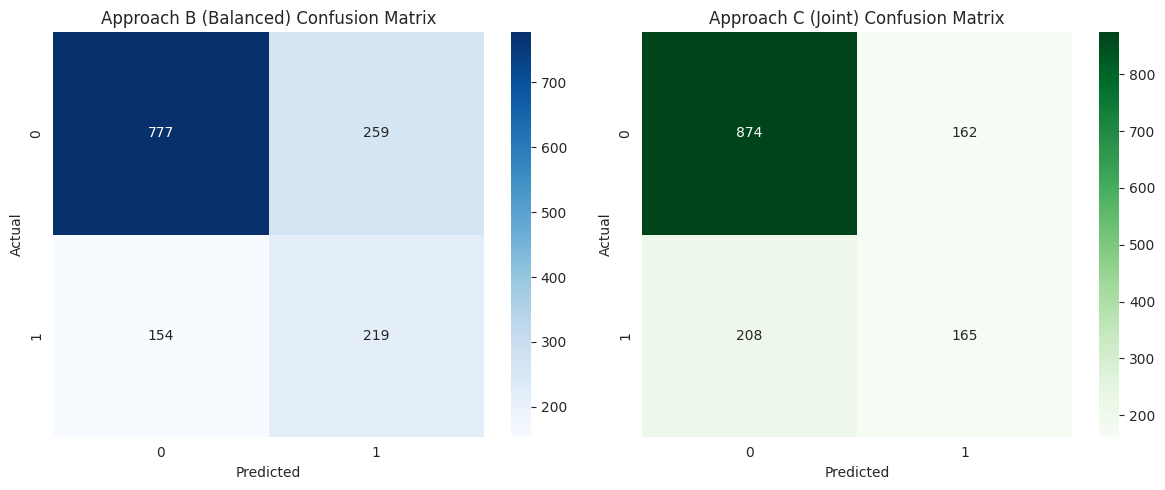

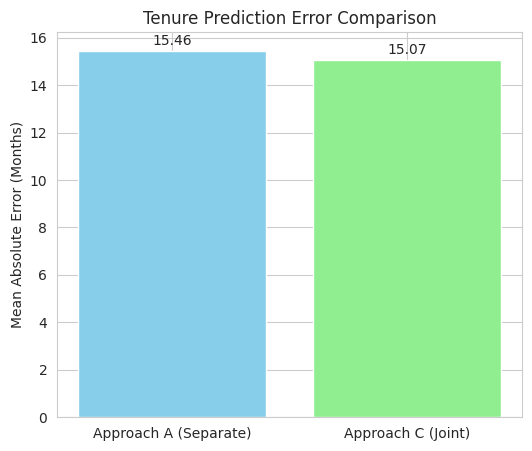

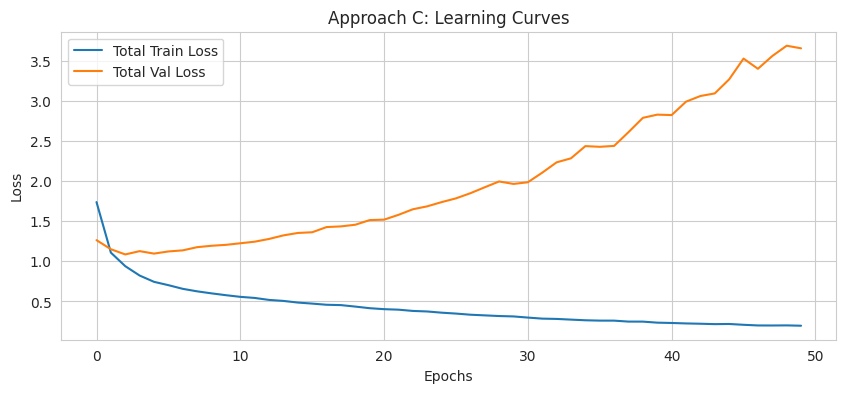

In [19]:
# Module 7: Visualization and Comparison

# 1. Confusion Matrix Comparison (Approach B Balanced vs C)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_churn_test, preds_b_bal), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Approach B (Balanced) Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_churn_test, pred_churn_c), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Approach C (Joint) Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 2. Tenure Error Comparison (A vs C)
errors = [mae_a, mae_c]
labels = ['Approach A (Separate)', 'Approach C (Joint)']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, errors, color=['skyblue', 'lightgreen'])
plt.ylabel('Mean Absolute Error (Months)')
plt.title('Tenure Prediction Error Comparison')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')

plt.show()

# 3. Training Loss for Joint Model
plt.figure(figsize=(10, 4))
plt.plot(history_c.history['loss'], label='Total Train Loss')
plt.plot(history_c.history['val_loss'], label='Total Val Loss')
plt.title('Approach C: Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Module 8: Diagnostic Visualizations

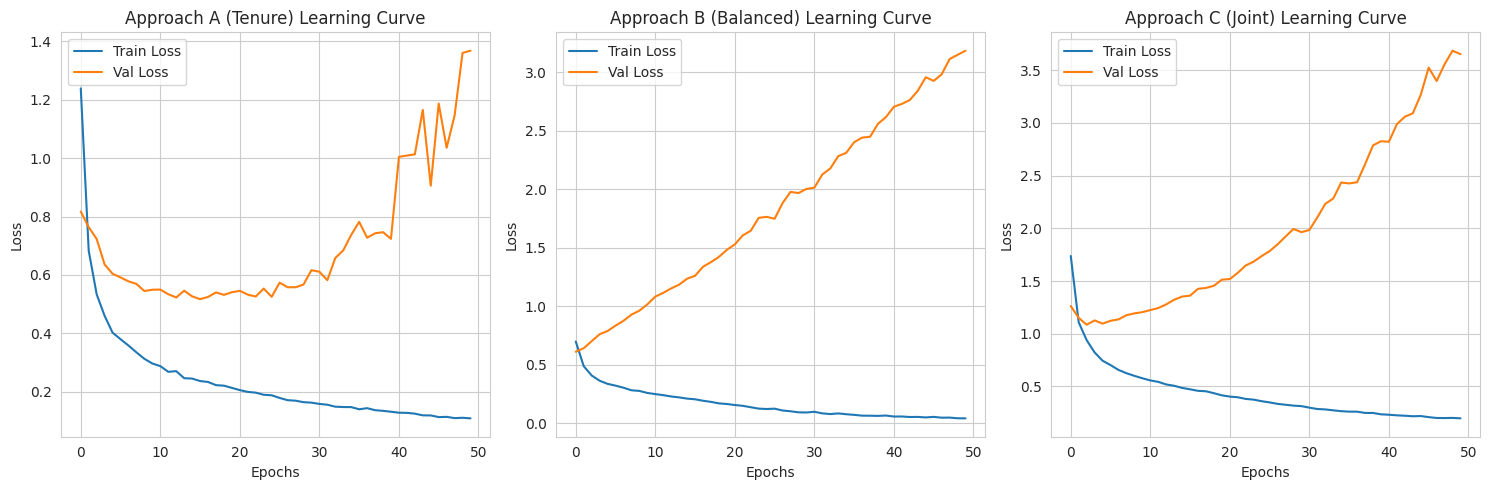

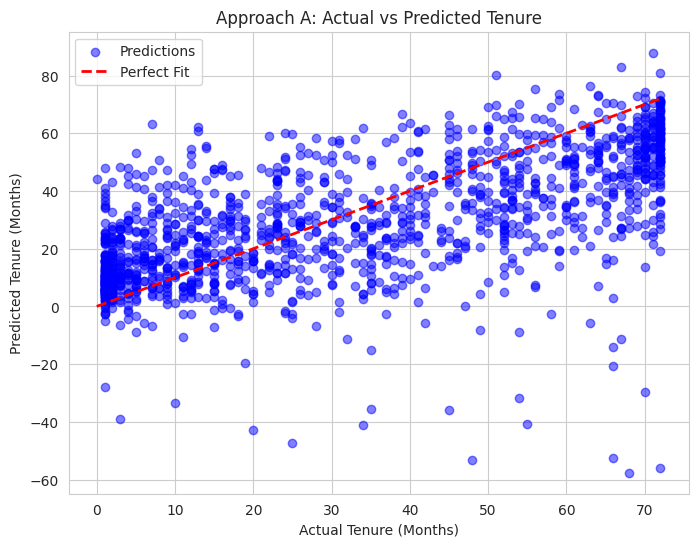

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


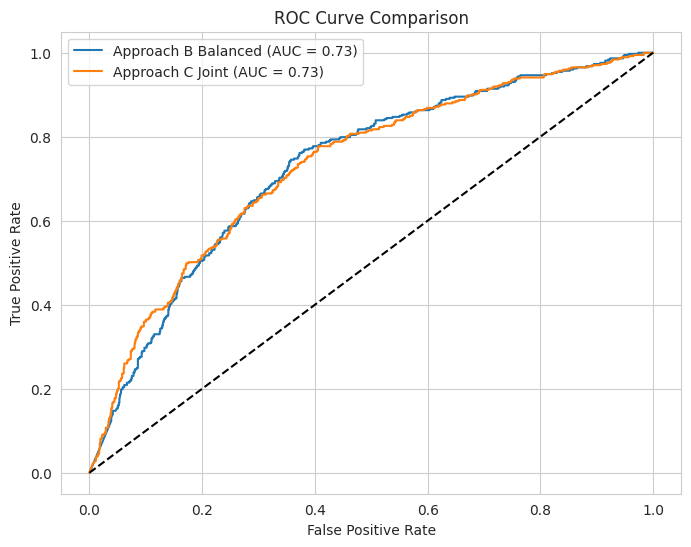

In [20]:
# Module 8: Diagnostic Visualizations
from sklearn.metrics import roc_curve, auc

def plot_learning_curves(histories, titles):
    """
    Plots training vs validation loss for multiple models.
    """
    plt.figure(figsize=(15, 5))

    for i, (history, title) in enumerate(zip(histories, titles)):
        plt.subplot(1, len(histories), i+1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{title} Learning Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 1. Plot Loss Curves (A, B, C)
# Note: Ensure you assigned history_b_bal in Module 5!
plot_learning_curves(
    [history_a, history_b_bal, history_c],
    ['Approach A (Tenure)', 'Approach B (Balanced)', 'Approach C (Joint)']
)

# 2. Tenure Regression Fit (Actual vs Predicted)
# Ideally, points should lie on the red diagonal line.
plt.figure(figsize=(8, 6))
plt.scatter(y_ten_test_raw, pred_tenure_a, alpha=0.5, color='blue', label='Predictions')
plt.plot([0, 72], [0, 72], color='red', linestyle='--', linewidth=2, label='Perfect Fit')
plt.title('Approach A: Actual vs Predicted Tenure')
plt.xlabel('Actual Tenure (Months)')
plt.ylabel('Predicted Tenure (Months)')
plt.legend()
plt.grid(True)
plt.show()

# 3. ROC Curve for Churn (Approach B vs C)
# ROC is standard for analyzing binary classification trade-offs
fpr_b, tpr_b, _ = roc_curve(y_churn_test, model_b_bal.predict(X_test))
auc_b = auc(fpr_b, tpr_b)

# For C, we use the 2nd output (Churn probs)
fpr_c, tpr_c, _ = roc_curve(y_churn_test, pred_churn_probs_c)
auc_c = auc(fpr_c, tpr_c)

plt.figure(figsize=(8, 6))
plt.plot(fpr_b, tpr_b, label=f'Approach B Balanced (AUC = {auc_b:.2f})')
plt.plot(fpr_c, tpr_c, label=f'Approach C Joint (AUC = {auc_c:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Module 9 - Hyper Parameter Tuning

In [22]:
# Module 9: Advanced Hyperparameter Experimentation
from tensorflow.keras.callbacks import EarlyStopping

def build_experimental_model(input_dim, learning_rate=0.001, hidden_layers=[64, 32], dropout_rate=0.2):
    input_layer = Input(shape=(input_dim,))

    x = input_layer
    for neurons in hidden_layers:
        x = Dense(neurons, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    out_tenure = Dense(1, activation='linear', name='tenure')(x)
    out_churn = Dense(1, activation='sigmoid', name='churn')(x)

    model = Model(inputs=input_layer, outputs=[out_tenure, out_churn])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss={'tenure': 'mse', 'churn': 'binary_crossentropy'},
        loss_weights=[1.0, 1.0],
        metrics={'tenure': 'mae', 'churn': 'accuracy'}
    )
    return model

# Define Experiments (Added Batch Size & More LR options)
experiments = [
    {'name': 'Baseline (BS=32)', 'lr': 0.001, 'layers': [64, 32], 'dropout': 0.2, 'batch_size': 32},
    {'name': 'Large Batch (BS=64)', 'lr': 0.001, 'layers': [64, 32], 'dropout': 0.2, 'batch_size': 64},
    {'name': 'Deep Network', 'lr': 0.001, 'layers': [128, 64, 32], 'dropout': 0.3, 'batch_size': 32},
    {'name': 'Low LR (0.0005)', 'lr': 0.0005, 'layers': [64, 32], 'dropout': 0.2, 'batch_size': 32}
]

results = []

# Define Early Stopping
# Stop if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=0
)

print("Starting Advanced Experiments...")

for exp in experiments:
    print(f"Running: {exp['name']}")

    model = build_experimental_model(
        input_dim=X_train.shape[1],
        learning_rate=exp['lr'],
        hidden_layers=exp['layers'],
        dropout_rate=exp['dropout']
    )

    # Train with Early Stopping
    history = model.fit(
        X_train, [y_ten_train_s, y_churn_train],
        validation_split=0.2,
        epochs=100, # Set high, let EarlyStopping decide when to stop
        batch_size=exp['batch_size'],
        callbacks=[early_stop], # <--- The Magic Component
        verbose=0
    )

    # Evaluate
    preds = model.predict(X_test, verbose=0)
    pred_ten = scaler_tenure.inverse_transform(preds[0])
    pred_churn = (preds[1] > 0.5).astype(int)

    results.append({
        'Experiment': exp['name'],
        'Tenure MAE': mean_absolute_error(y_ten_test_raw, pred_ten),
        'Churn Acc': accuracy_score(y_churn_test, pred_churn),
        'Churn F1': f1_score(y_churn_test, pred_churn),
        'Epochs Run': len(history.history['loss']) # Track how early it stopped
    })

# Display Results
results_df = pd.DataFrame(results)
print("\n--- Final Experimentation Results ---")
print(results_df)

Starting Advanced Experiments...
Running: Baseline (BS=32)
Running: Large Batch (BS=64)
Running: Deep Network
Running: Low LR (0.0005)

--- Final Experimentation Results ---
            Experiment  Tenure MAE  Churn Acc  Churn F1  Epochs Run
0     Baseline (BS=32)   15.193362   0.749468  0.480118          13
1  Large Batch (BS=64)   15.420020   0.744500  0.461078          12
2         Deep Network   16.578650   0.750177  0.352941          10
3      Low LR (0.0005)   15.847072   0.760114  0.486322          15
